# FloPy VTK/PyVista particle tracking pathline visualization demo

This notebook arranges and runs a steady state MODFLOW 6 groundwater flow model, then a MODPATH 7 particle tracking model, using the Freyberg grid. Particle tracks are exported to VTK files, then loaded and visualized with [PyVista](https://docs.pyvista.org/version/stable/index.html). Finally an animation of particle motion is created with VTK's Python API.

First, import FloPy and show the version.

In [18]:
import sys
import flopy

print(sys.version)
print("flopy version: {}".format(flopy.__version__))

3.10.5 (v3.10.5:f377153967, Jun  6 2022, 12:36:10) [Clang 13.0.0 (clang-1300.0.29.30)]
flopy version: 3.3.7


Load the Freyberg groundwater flow model.

In [19]:
from pathlib import Path
from flopy.mf6 import MFSimulation

mdl_name = "freyberg"
sim_name = f"mf6-{mdl_name}-vtk-pathlines"
sim_path = Path.cwd().parent / "data" / f"mf6-{mdl_name}"

sim = MFSimulation.load(
    sim_name=sim_name,
    sim_ws=sim_path
)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package sto...
    loading package chd...
    loading package riv...
    loading package wel...
    loading package rch...
  loading solution package freyberg...


Create a temporary directory and change the simulation's workspace.

In [20]:
from tempfile import TemporaryDirectory

temp_path = TemporaryDirectory()
workspace = Path(temp_path.name)
sim.set_sim_path(workspace)

Write the input files to the temporary workspace.

In [21]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package freyberg...
  writing model freyberg...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package sto...
    writing package chd_0...
    writing package riv_0...
    writing package wel_0...
    writing package rch_0...


Run the groundwater flow simulation.

In [22]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../../../../../Users/wes/.local/share/flopy/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.3.0 03/04/2022

   MODFLOW 6 compiled Mar 07 2022 13:50:09 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.5.0
                             Build 20211109_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither th

(True, [])

Define particle release locations.

In [23]:
pgs = []
gwf = sim.get_model(mdl_name)

for i in range(1, 5):
    nrow = gwf.modelgrid.nrow
    ncol = gwf.modelgrid.ncol
    m = i * 2 if i < 3 else (nrow - i * 4)
    n = i *2 if i < 3 else (ncol - i * 4)
    celldata = flopy.modpath.CellDataType(drape=0)
    lrcpd = flopy.modpath.LRCParticleData(
        subdivisiondata=[celldata],
        lrcregions=[[[0, m, n, 0, m + 1, n + 1]]],
    )
    pg = flopy.modpath.ParticleGroupLRCTemplate(
        particlegroupname=f"PG{i}", particledata=lrcpd, filename=f"{sim_name}.pg{i}.sloc"
    )
    pgs.append(pg)

Retrieve well locations.

In [24]:
import numpy as np

wel_locs = [(rec[0][1], rec[0][2]) for rec in (gwf.wel.stress_period_data.data[0])]
print(wel_locs)

[(8, 15), (10, 12), (19, 13), (25, 9), (28, 5), (33, 11)]


Define particle termination zones.

In [25]:
import numpy as np

zone_maps = []

# zone 1 is the default (non-terminating regions)
def fill_zone_1():
    return np.ones((nrow, ncol), dtype=np.int32)

za = fill_zone_1()
for wl in wel_locs:
    za[wl] = 2  # wells
za[:,14] = 3  # river
zone_maps.append(za)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1,

Create a MODPATH 7 simulation forward tracking model in pathline mode.

In [26]:
mp = flopy.modpath.Modpath7(
    modelname=f"{sim_name}_mp",
    flowmodel=gwf,
    exe_name="mp7",
    model_ws=workspace,
)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1)
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype="combined",
    trackingdirection="forward",
    budgetoutputoption="summary",
    zonedataoption="on",
    zones=zone_maps,
    particlegroups=pgs,
)

Write and run the particle tracking model.

In [27]:
mp.write_input()
mp.run_model()

FloPy is using the following executable to run the model: ../../../../../../Users/wes/.local/share/flopy/bin/mp7

MODPATH Version 7.2.001   
Program compiled Mar 07 2022 14:08:27 with IFORT compiler (ver. 20.21.5)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+01  Steady-state flow                                                    

Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
       417 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
        15 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                     

(True, [])

Open the pathline output file and read pathline data.

In [28]:
from flopy.utils import PathlineFile

pf = PathlineFile(workspace / mpsim.pathlinefilename)
pl = pf.get_alldata()

Plot the grid, heads, boundary conditions, and pathlines.

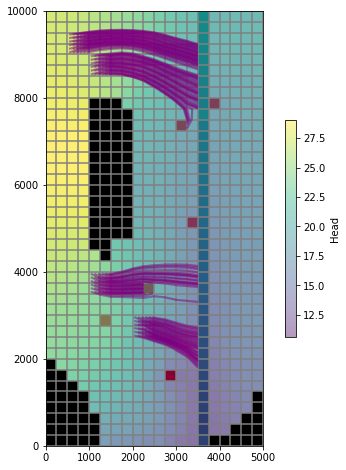

In [29]:
import matplotlib.pyplot as plt

hf = flopy.utils.HeadFile(workspace / f"{mdl_name}.hds")
hds = hf.get_data()
        
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mv = flopy.plot.PlotMapView(model=gwf)
mv.plot_grid()
mv.plot_ibound()
mv.plot_bc("RIV")
mv.plot_bc("WEL", plotAll=True)
hd = mv.plot_array(hds, alpha=0.4)
cb = plt.colorbar(hd, shrink=0.5)
cb.set_label("Head")
mv.plot_pathline(pl, layer="all", alpha=0.1, colors=["purple"], lw=2)
plt.show()

Create a `Vtk` object, add the flow model outputs and pathlines, and export VTK files.

In [30]:
from flopy.export.vtk import Vtk

vtk = Vtk(model=gwf, binary=False, vertical_exageration=50, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(pl)

vtk_path = workspace / f"{sim_name}.vtk"
vtk.write(vtk_path)

Two VTK files were exported, one containing the grid and flow model data, the other containing particle tracks and associated data.

Read the VTK files into PyVista meshes.

In [31]:
import pyvista as pv

grid = pv.read(workspace / f"{vtk_path.stem}_000000.vtk")
pls = pv.read(workspace / f"{vtk_path.stem}_pathline.vtk")

Rotate the meshes. (Why are they upside-down?)

In [32]:
axes = pv.Axes(show_actor=True, actor_scale=2.0, line_width=5)

grid.rotate_z(160, point=axes.origin, inplace=True)
pls.rotate_z(160, point=axes.origin, inplace=True)

UnstructuredGrid (0x13293ef20)
  N Cells:    48921
  N Points:   48489
  X Bounds:   -6.449e+03, -2.190e+03
  Y Bounds:   -8.703e+03, -4.954e+02
  Z Bounds:   1.135e+02, 1.289e+03
  N Arrays:   2

Check some grid properties to make sure the export succeeded.

In [33]:
from pprint import pprint

assert grid.n_cells == gwf.modelgrid.nnodes
print("Grid has", grid.n_cells, "cells")
print("Grid has", grid.n_arrays, "arrays")
assert grid.n_arrays > 0
pprint(grid.array_names)

Grid has 800 cells
Grid has 15 arrays
['top',
 'botm',
 'idomain',
 'strt',
 'icelltype',
 'k',
 'iconvert',
 'ss',
 'sy',
 'chd_0_head',
 'riv_0_stage',
 'riv_0_cond',
 'riv_0_rbot',
 'wel_0_q',
 'recharge']


View the grid and pathlines with PyVista, with particle locations colored by time.

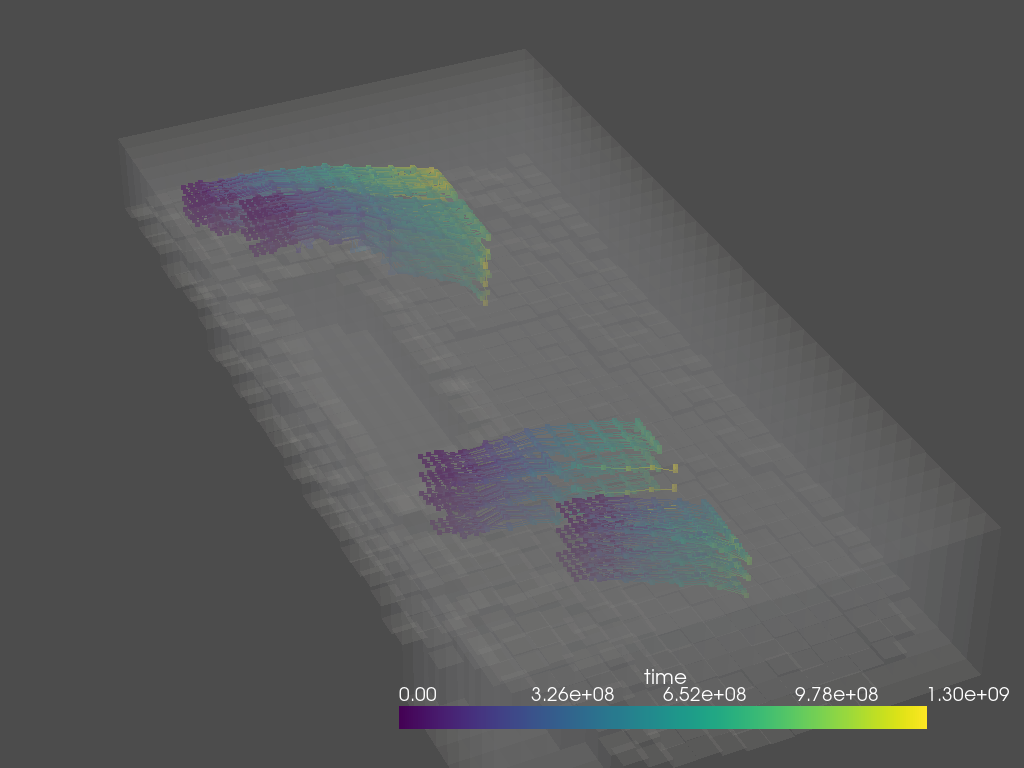

In [40]:
pv.set_jupyter_backend('static')

p = pv.Plotter()
p.add_mesh(grid, opacity=0.07)
p.add_mesh(pls, scalars="time")
p.camera.zoom(1.8)
p.show()